# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_run(results, standalone=True):
    if standalone:
        plt.subplots(figsize=(15, 15))
    
    #查看四轴飞行器的位置变化
    plt.subplot(3, 3, 1)
    plt.title('Position')
    plt.plot(results['time'], results['x'], label='x')
    plt.plot(results['time'], results['y'], label='y')
    plt.plot(results['time'], results['z'], label='z')
    plt.xlabel('time, seconds')
    plt.ylabel('Position')
    plt.grid(True)
    if standalone:
        plt.legend()

    #四轴飞行器的速度
    plt.subplot(3, 3, 2)
    plt.title('Velocity')
    plt.plot(results['time'], results['x_velocity'], label='x_hat')
    plt.plot(results['time'], results['y_velocity'], label='y_hat')
    plt.plot(results['time'], results['z_velocity'], label='z_hat')
    plt.xlabel('time, seconds')
    plt.ylabel('Velocity')
    plt.grid(True)
    if standalone:
        plt.legend()
    
    #绘制欧拉角 (Euler angles)（四轴飞行器围绕 x，y 和 z 轴的旋转）的图表
    plt.subplot(3, 3, 3)
    plt.title('Orientation')
    plt.plot(results['time'], results['phi'], label='phi')
    plt.plot(results['time'], results['theta'], label='theta')
    plt.plot(results['time'], results['psi'], label='psi')
    plt.xlabel('time, seconds')
    plt.grid(True)
    if standalone:
        plt.legend()
    
    #绘制每个欧拉角的速度（每秒的弧度）图
    plt.subplot(3, 3, 4)
    plt.title('Angular Velocity')
    plt.plot(results['time'], results['phi_velocity'], label='phi')
    plt.plot(results['time'], results['theta_velocity'], label='theta')
    plt.plot(results['time'], results['psi_velocity'], label='psi')
    plt.xlabel('time, seconds')
    plt.grid(True)
    if standalone:
        plt.legend()

    #最后，你可以使用下方代码来输出智能体选择的动作。
    plt.subplot(3, 3, 5)
    plt.title('Rotor Speed')
    plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1')
    plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2')
    plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3')
    plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4')
    plt.xlabel('time, seconds')
    plt.ylabel('Rotor Speed, revolutions / second')
    plt.grid(True)
    if standalone:
        plt.legend()

    if standalone:
        plt.tight_layout()
        plt.show()

In [2]:
from mpl_toolkits.mplot3d.axes3d import Axes3D


def plot_point3d(ax, x, y, z, **kwargs):
    ax.scatter([x], [y], [z], **kwargs)
    ax.text(x, y, z, "({:.1f}, {:.1f}, {:.1f})".format(x, y, z))


def show_flight_path(results, target=None):
    results = np.array(results)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    ax.plot3D(results[:, 0], results[:, 1], results[:, 2], 'gray')
    
    if target is not None:
        plot_point3d(ax, *target[0:3], c='y', marker='x', s=100, label='target')
        
    plot_point3d(ax, *results[0, 0:3], c='g', marker='o', s=50, label='start')
    plot_point3d(ax, *results[-1, 0:3], c='r', marker='o', s=50, label='end')
    
    ax.legend()

In [3]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [4]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [10]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-22.15869198  21.90141831  20.7457586    0.59736468   0.58084611
   0.        ]
[-13.44423967  10.15199484  -2.21797184]
[0.0517015  0.05197223 0.        ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [11]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes =10
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode =   10, score =  -1.747 (best =  -0.136), noise_scale = 3.255

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [36]:
## TODO: Train your agent here.
import sys
import pandas as pd
from agents.agent import DDPG
from task import Task

num_episodes = 1200
init_pose = np.array([0., 0., 2., 0., 0., 0.])
target_pos = np.array([0., 0., 10.])
task = Task(init_pose=init_pose,target_pos=target_pos)
agent = DDPG(task) 

labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
all_results = []
plot_data = {x : [] for x in ['episode', 'total_reward']}

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    results = {x : [] for x in labels}
    
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action=action, reward=reward, next_state=next_state, done=done)
        state = next_state
        
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])

        
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} ,total_reward={:7.3f}， (best = {:7.3f})".format(
                i_episode, agent.score, agent.total_reward, agent.best_score), end="")  # [debug]

            all_results.append(results)
            plot_data['episode'].append(i_episode)
            plot_data['total_reward'].append(agent.total_reward)
            break
    sys.stdout.flush()

Episode = 1200, score =  14.584 ,total_reward=277.102， (best =  14.618))))

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

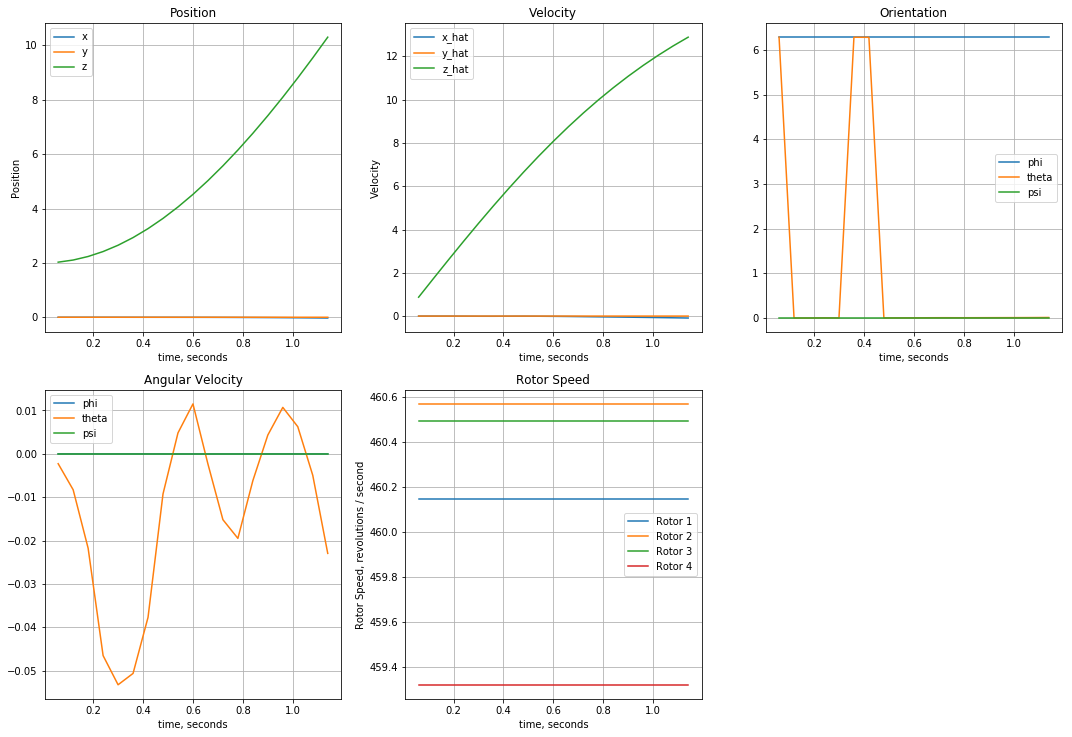

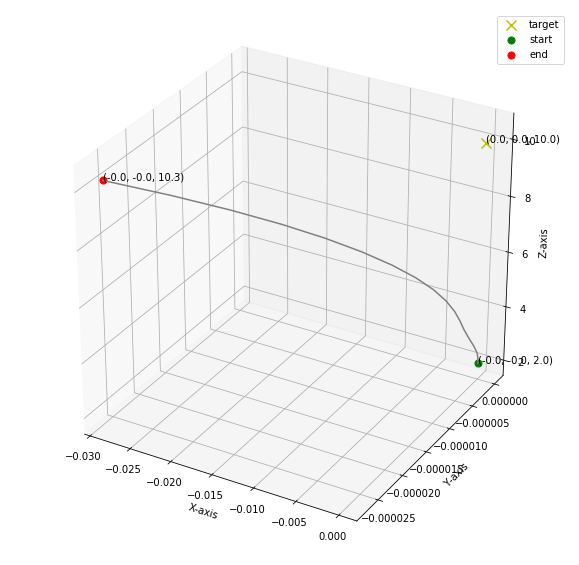

In [37]:
plot_run(results)

path = [[results['x'][i], results['y'][i], results['z'][i]] for i in range(len(results['x']))]
show_flight_path(path, target=target_pos)

/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


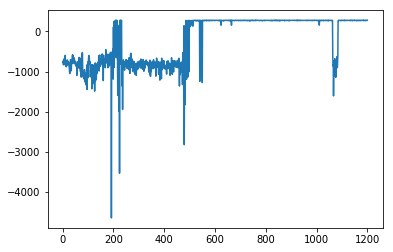

In [38]:
## TODO: Plot the rewards.
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the rewards
plt.plot(plot_data['episode'], plot_data['total_reward'])

plt.legend()
_ = plt.ylim()

In [42]:
# Final Performance 
print("Final Performance (Mean Reward over last 10 episodes): {}.".format(np.sum(plot_data['total_reward'][-10:])/10))

Final Performance (Mean Reward over last 10 episodes): 274.4707546673069.


## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:
Agent起点为（0,0,2）,终点为（0，0,10）。
实际位置与目标位置的距离越近奖励越高，与目标位置距离越远奖励越低。Agent的Z方向上升速度越大，奖励越高。Agent的角速度变化越小，奖励越高，以便飞行更平稳。同时减去常量1.0，训练让agent减少step，尽快到达目标。

 ```
     def get_reward(self):
        """Uses current pose of sim to return reward."""
        #return reward
        reward = 0.0
        # Reward positive velocity along z-axis
        reward_vz = self.sim.v[2]
        # Reward positions close to target along z-axis
        reward_posz = -(abs(self.sim.pose[2] - self.target_pos[2]))
        # Reward positions close to target along  xy-plane
        reward_posxy = -(abs(self.sim.pose[:2] - self.target_pos[:2])).sum()
        # Reward smooth changing in angular 
        reward_ang= -(abs(self.sim.angular_v[:3])).sum()*0.5 
        return reward_vz+reward_posz+reward_posxy+reward_ang-1.0```

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:
选择了课程里推荐的DDPG算法。
 超参数选择了learning_rate = 0.001,gamma = 0.99,Episode = 1200，buffer_size = 100000，batch_size = 128。
 Actor隐藏层使用了大小分别为32，64，32的全连接层,激活函数为 relu，每个全连接层之后添加了Batch Norm和Dropout层；输出层使用 sigmoid 激活函数,Critic state 和 action 隐藏层使用了大小为 32，64的全连接层，激活函数为relu，每个全连接层之后添加了Batch Norm和Dropout层； 最后把state 和 action 联合起来。



**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:
该学习任务比较简单。
学习曲线中前期在某一些episode附近奖励循序上升，大体是处于震荡阶段。在500个episode附近，reward急速上升。
agent的最终total reward收敛于274.47（最后十个阶段的平均奖励值）。

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:
设计任务奖励和设计智能体是最困难的部分。超参数也需要多次调整。
有趣的是在500 episode后，agent突然获得了更多的奖励，并且趋于稳定。